In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
import matplotlib.colors as mcolors

c1 = 'tab:blue'   #S
c2 = 'tab:orange' #E
c3 = 'tab:green'  #I
c4 = 'tab:red'    #R
c5 = 'tab:purple' #D
c6 = 'tab:brown'  #Hospital
c7 = 'tab:pink'   #Outside
c8 = 'tab:gray'   #Positive
c9 = 'tab:olive'  #R(t)in
c10= 'tab:cyan'   #R(t)out

# Parameters set

In [3]:
# parameters

t_max = 180             # simulation duration
dt    = 0.01
pop   = 1000000         # total population
b     = 1
m     = 0.04
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007
rh    = 0.093
do    = 0.010
ro    = 0.090

# initial state

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [4]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [5]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [6]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22
    
    df['deltaDh']     = dh * df[2]
    df['deltaDo']     = do * df[7]
    df['deltaDead']   = df['deltaDh'] + df['deltaDo']

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [7]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['Hospitalised']),np.max(df_['Dead'])]

In [8]:
def tSEIRD_max_(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]
    
    df['Io'] = df[7]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    df['dDead'] = dh * df['Ih'] + do * df['Io']
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [dt*np.argmax(df_['Positive']),
            dt*np.argmax(df_['Hospitalised']),
            dt*np.argmax(df_['dDead'])
           ]

# Time-course of three variables

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


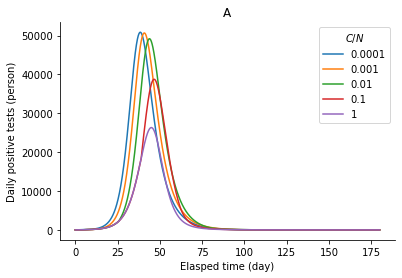

In [33]:
fig, ax = plt.subplots()
ax.set_title('A')

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.0001)[['Positive']]
l1 = '0.0001'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.001)[['Positive']]
l2 = '0.001'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.01)[['Positive']]
l3 = '0.01'
ax.plot(t, y3, color=c3, label=l3)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1)[['Positive']]
l4 = '0.1'
ax.plot(t, y4, color=c4, label=l4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['Positive']]
l5 = '1'
ax.plot(t, y5, color=c5, label=l5)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Daily positive tests (person)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

ax.legend(loc=0)
plt.legend(title='$\it{C / N}$')

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


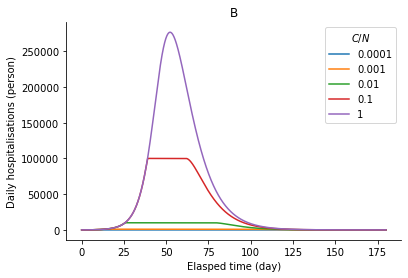

In [34]:
fig, ax = plt.subplots()
ax.set_title('B')

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.0001)[['Hospitalised']]
l1 = '0.0001'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.001)[['Hospitalised']]
l2 = '0.001'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.01)[['Hospitalised']]
l3 = '0.01'
ax.plot(t, y3, color=c3, label=l3)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1)[['Hospitalised']]
l4 = '0.1'
ax.plot(t, y4, color=c4, label=l4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['Hospitalised']]
l5 = '1'
ax.plot(t, y5, color=c5, label=l5)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Daily hospitalisations (person)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

ax.legend(loc=0)
plt.legend(title='$\it{C / N}$')

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


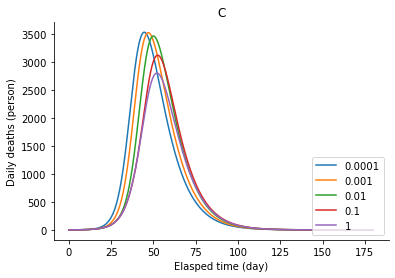

In [39]:
fig, ax = plt.subplots()
ax.set_title('C')

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.0001)[['deltaDead']]
l1 = '0.0001'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.001)[['deltaDead']]
l2 = '0.001'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.01)[['deltaDead']]
l3 = '0.01'
ax.plot(t, y3, color=c3, label=l3)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1)[['deltaDead']]
l4 = '0.1'
ax.plot(t, y4, color=c4, label=l4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['deltaDead']]
l5 = '1'
ax.plot(t, y5, color=c5, label=l5)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Daily deaths (person)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(title='$\it{C / N}$')
ax.legend(loc=4)

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


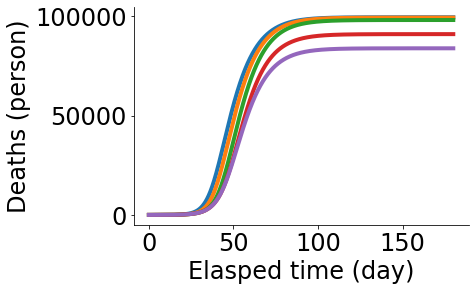

In [12]:
# Fig3C boxed

fig, ax = plt.subplots()
ax.set_title("")

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.0001)[['Dead']]
l1 = '0.0001'
ax.plot(t, y1, color=c1, label=l1, linewidth=4)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.001)[['Dead']]
l2 = '0.001'
ax.plot(t, y2, color=c2, label=l2, linewidth=4)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.01)[['Dead']]
l3 = '0.01'
ax.plot(t, y3, color=c3, label=l3, linewidth=4)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1)[['Dead']]
l4 = '0.1'
ax.plot(t, y4, color=c4, label=l4, linewidth=4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01,1)[['Dead']]
l5 = '1'
ax.plot(t, y5, color=c5, label=l5, linewidth=4)

plt.xlabel('Elasped time (day)', fontsize=24)
plt.ylabel('Deaths (person)', fontsize=24)
plt.tick_params(labelsize=24)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

# Coverage ratio and the maximum number

In [13]:
var_cap = []
for i in np.linspace(0, 1, 101):
    var_cap.append(tSEIRD_max(0.7, 0.7, 0.5, 0.01, i))

var_cap_np = np.array(var_cap)
# three variables varying examination behaviour

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


In [14]:
df_var_cap = pd.DataFrame({'p': np.linspace(0, 1, 101),
                         'Positive Population': var_cap_np[:, 0],
                         'Hospitalised Population': var_cap_np[:, 1],
                         'Death': var_cap_np[:, 2]
                         })

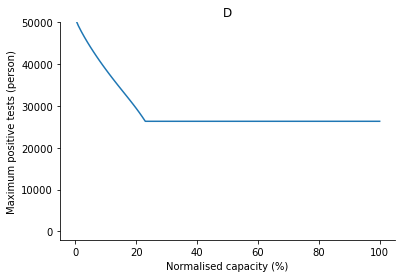

In [28]:
fig = df_var_cap['Positive Population'].plot.line()

fig.set_xlabel('Normalised capacity (%)')
fig.set_ylabel('Maximum positive tests (person)')
fig.set_title('D')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.ylim(-2000,50000)

plt.show()

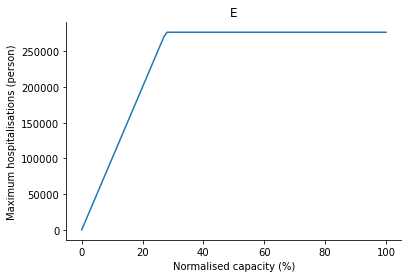

In [27]:
fig = df_var_cap['Hospitalised Population'].plot.line()

fig.set_xlabel('Normalised capacity (%)')
fig.set_ylabel('Maximum hospitalisations (person)')
fig.set_title('E')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

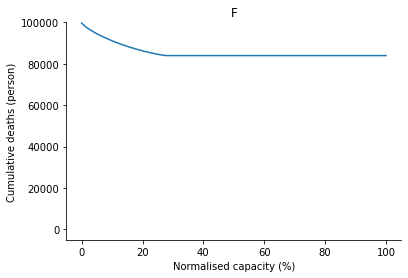

In [26]:
fig = df_var_cap['Death'].plot.line()

fig.set_xlabel('Normalised capacity (%)')
fig.set_ylabel('Cumulative deaths (person)')
fig.set_title('F')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.ylim(-5000,100000)

plt.show()

# Coverage ratio and the peaks

In [18]:
peak_cap = []
for i in np.linspace(0, 1, 101):
    peak_cap.append(tSEIRD_max_(0.7, 0.7, 0.5, 0.01, i))

peak_cap_np = np.array(peak_cap)

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


In [19]:
df_peak_cap = pd.DataFrame({'p': np.linspace(0, 1, 101),
                         'Positive Population': peak_cap_np[:, 0],
                         'Hospitalised Population': peak_cap_np[:, 1],
                         'Death': peak_cap_np[:, 2]
                         })

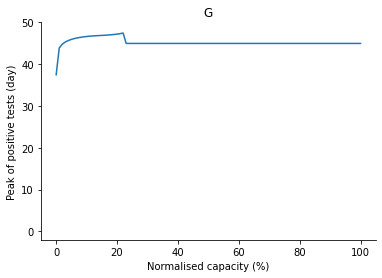

In [25]:
fig = df_peak_cap['Positive Population'].plot.line()

fig.set_xlabel('Normalised capacity (%)')
fig.set_ylabel('Peak of positive tests (day)')
fig.set_title('G')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.ylim(-2,50)

plt.show()

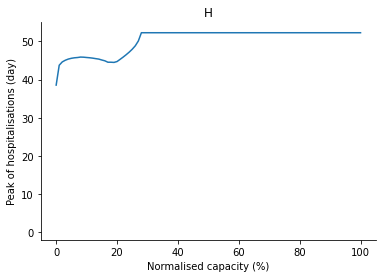

In [24]:
fig = df_peak_cap['Hospitalised Population'].plot.line()

fig.set_xlabel('Normalised capacity (%)')
fig.set_ylabel('Peak of hospitalisations (day)')
fig.set_title('H')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.ylim(-2,55)

plt.show()

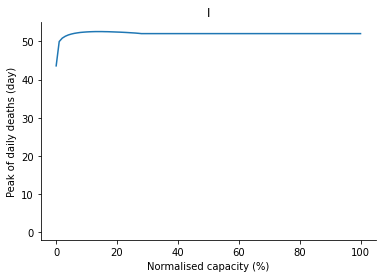

In [23]:
fig = df_peak_cap['Death'].plot.line()

fig.set_xlabel('Normalised capacity (%)')
fig.set_ylabel('Peak of daily deaths (day)')
fig.set_title('I')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.ylim(-2,55)

plt.show()